# Elly

### Initial setup

In [34]:
from scipy import optimize
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
from openplaning import PlaningBoat
sys.path.append("../../")
from vessel_model_tuning_lib import ship_dimensions, maneuvering, resistance, seakeeping, vessel_model_common, actuators

plt.style.use('bmh')

## Vessel data input section
For transparency, all input data used to create the vessel model should be stated in this section. All data used to override default values should also be defined here.

In [35]:
'''
Main dimensions
'''
ship_name = 'Elly'
Lpp = 8.0 # Length between the perpendiculars
B = 3.169 # Beam in the water line
T = 0.7 # Draft
mass = 7200 # Light ship + typical loading condition

'''
Additional known data used in the modelling
'''
Loa = 9.246 #Length over all (used in quay collision model)
water_density = 1025.0 # Froja operates in freshwater
lcg = 2.725 # m from AP
vcg = 1.054 # m above baseline
GM_roll = 1.249 # Transverse metacentric height
max_speed_knots = 34.0 # From Minne master thesis
max_displacement_speed_knots = 8.0 # From Minne master thesis
max_pre_planing_speed_knots = 17.0 # From Minne master thesis
deadrise = 23.7 #deg, from Minne master thesis

#Aerodynamics
frontal_area = 8.43 # m^2, from Minne master thesis
lateral_area = 9.94 # m^2, from Minne master thesis
rho_air = 1.23
blendermann_CDt = 0.9
blendermann_CDlAf = 0.55
blendermann_delta = 0.6
blendermann_kappa = 1.1

#Propeller
propeller_diameter = 16*0.0254 + 0.05 # 16 inches + a little extra to account counter rotating propeller
probeller_pitch = 23*0.0254 # 23 inches
propeller_blades = 4
epsilon = 0 #deg, thrust angle w.r.t. keel. Estimated from general arrangement drawings
vT = 0.2 #m, thrust vertical distance. Estimated from general arrangement drawings
lT = 0.0 #m, thrust horizontal distance. Estimated from general arrangement drawings
propeller_efficiency = 0.64 # From minne master thesis

#Propulsion system
max_motor_power = 302 #kW continuous
max_motor_torque = 770 # Nm continuous
max_motor_rpm = 3750 # rpm continuous
power_system_efficiency = 0.91 # Battery to propeller shaft

#Measured power output vs. speed from Minne master thesis Fig 26
datapoint_speed = np.array([5, 10, 15, 20, 25, 30])*vessel_model_common.knots_to_ms
datapoint_power = np.array([30, 140, 230, 250, 300, 350])*1e3


'''
Data estimated from tuning or model fitting
'''
propeller_geometry = actuators.PropellerGeometry.WAGENINGEN_B4_70_PD14 #Selected based on matching PD ratio. Real propellers are counter rotating
gear_ratio = 1.81 # From motor to propeller
max_rpm = max_motor_rpm / gear_ratio # Propeller
min_rpm = -max_rpm
CD_lateral = 0.1 #Extra resistance due to viscous effects (such as submerged transom stern)
GM_pitch = 8*GM_roll # longitudonal metacentric height. Tuned to get reasonable natural period of oscillation in seakeeping model
damping_ratio_heave = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_roll = 0.15 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_pitch = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response
maneuvering_timeconstant_sway= 5.0 #Tunable parameter to get desired maneuvering behavior
maneuvering_timeconstant_yaw = 3.0 #Tunable parameter to get desired maneuvering behavior

### Define the physical constants to be used in the modelling

In [33]:
physical_constants = vessel_model_common.physical_constants()

### Generate ship coefficients based on given main dimension using empirical formulat
If any coefficients are known, they can be overridden in the generated `ship_dimensions` object

In [36]:
ship_dim = ship_dimensions.ShipDimensions(Lpp, B, T, mass/physical_constants.rho)
ship_dim.print()
inertias = seakeeping.Inertias(ship_dim, physical_constants)#Set default values for inertias


Wetted surface:    22.0 m^2
Longitudonal center of gravity:    0.0 m
Longitudonal center of buoyancy:    0.0 m
Block coefficient: 0.3955
Prismatic coefficient: 0.7125
Mid section coefficient: 0.95
Water plane coefficient: 0.75


## Propeller tuning

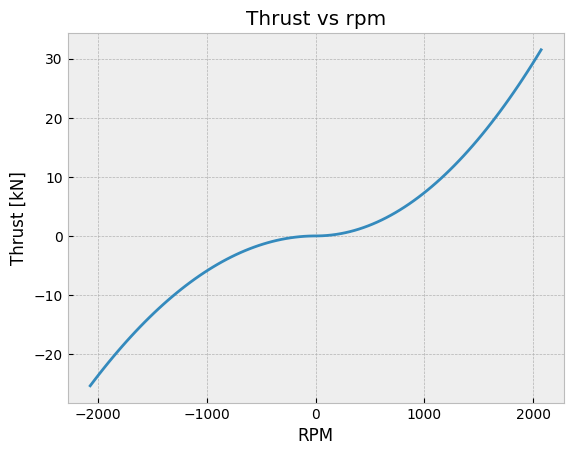

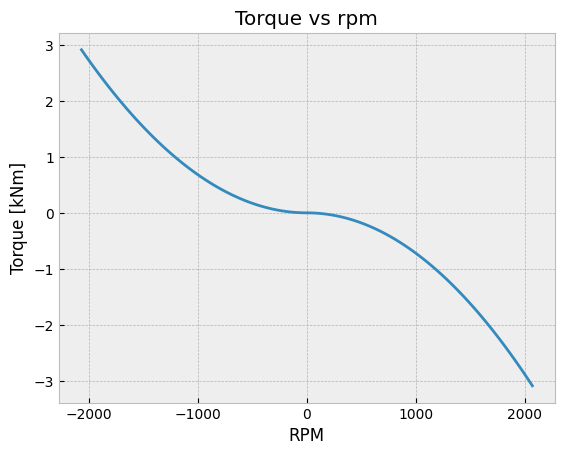

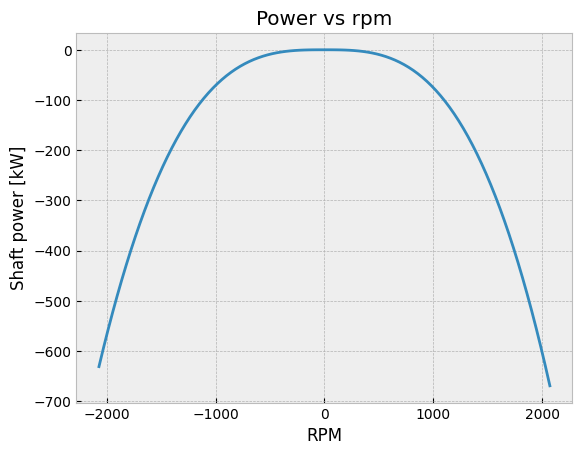

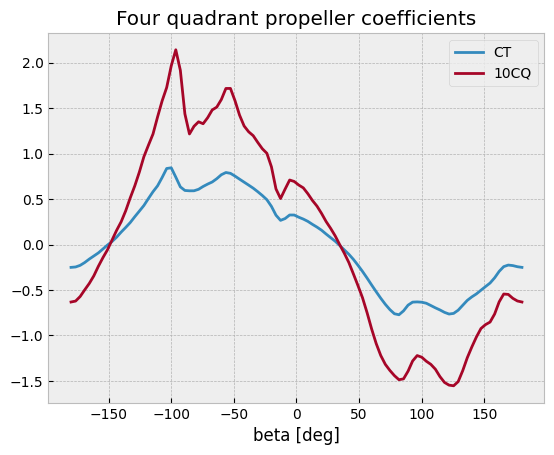

In [39]:
prop = actuators.FourQuadrantPropeller(propeller_geometry, propeller_diameter)

#Plot bollard pull thrust
speed = 0.0*vessel_model_common.knots_to_ms
rpm_list = np.linspace(min_rpm, max_rpm, 100)
thrust_ax, torque_ax, power_ax = prop.plot_thrust_torque_power_vs_rpm(rpm_list, speed)

#Plot four quadrant curves for propeller geometry
prop.four_quadrant_plot()
plt.show()


## Straight ahead resistance

Shape factor, k =  0.1153


/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.646, outside of range of applicability (1.0 <= U/sqrt(g*b) <= 13.00) for average bottom velocity estimate. Results are extrapolations.
  get_skin_friction()
/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.671, outside of range of applicability (1.0 <= U/sqrt(g*b) <= 13.00) for average bottom velocity estimate. Results are extrapolations.
  get_skin_friction()
/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.696, outside of range of applicability (1.0 <= U/sqrt(g*b) <= 13.00) for average bottom velocity estimate. Results are extrapolations.
  get_skin_friction()
/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.721, outside of range of applicabilit

/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.666, outside of range of applicability (1.0 <= U/sqrt(g*b) <= 13.00) for average bottom velocity estimate. Results are extrapolations.
  get_skin_friction()
/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.697, outside of range of applicability (1.0 <= U/sqrt(g*b) <= 13.00) for average bottom velocity estimate. Results are extrapolations.
  get_skin_friction()
/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.729, outside of range of applicability (1.0 <= U/sqrt(g*b) <= 13.00) for average bottom velocity estimate. Results are extrapolations.
  get_skin_friction()
/home/tobiastorben/.local/lib/python3.10/site-packages/openplaning/openplaning.py:681: UserWarning: Beam Froude number = 0.761, outside of range of applicabilit

Text(0, 0.5, 'Trim [deg]')

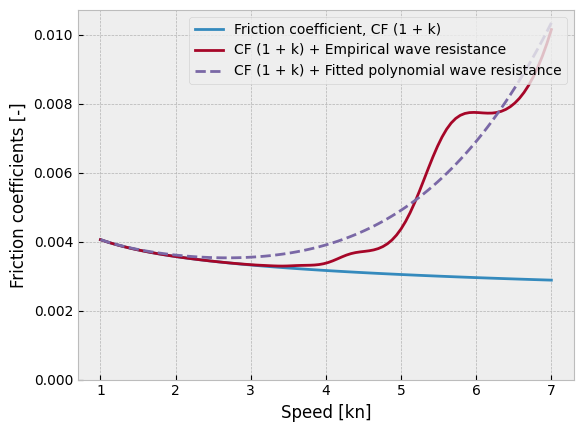

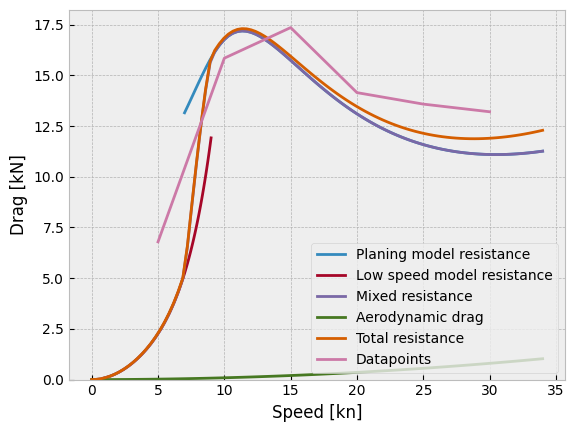

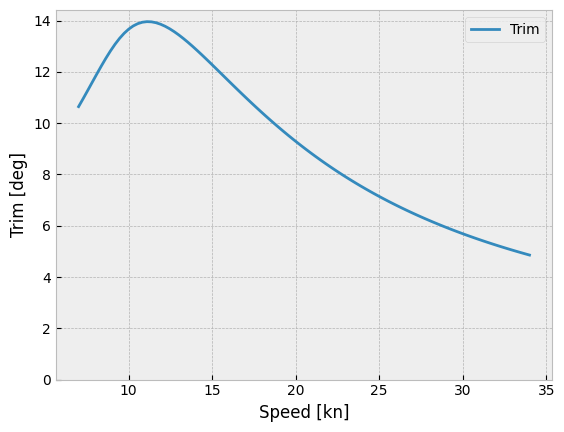

In [41]:
### Low speed model ###
n = 100
U_res_knots = np.linspace(0, max_speed_knots, n)
U_res = U_res_knots*vessel_model_common.knots_to_ms
U_res_low_knots = np.linspace(1, max_displacement_speed_knots + 1, n)
U_res_low = U_res_low_knots * vessel_model_common.knots_to_ms

U_res_fit_knots = np.linspace(1, max_displacement_speed_knots - 1, n)
U_res_fit = U_res_fit_knots * vessel_model_common.knots_to_ms
Fr = U_res_fit / np.sqrt(ship_dim.L * physical_constants.g) #Froude number based on length
k = resistance.marintek_shape_factor(ship_dim) #Empirical shape factor based on MARINTEK formula
print('Shape factor, k = ', np.round(k, 4))
CR = np.zeros(n)
CF = np.zeros(n)
for i in range(n):
    CR[i] = resistance.holtrop_wave_resistance(ship_dim, U_res_fit[i], physical_constants.g, physical_constants.rho) # Resistance coeff due to wave generation (empirical based on Holtrop's method)
    CF[i] = resistance.CF_ITTC(ship_dim, U_res_fit[i], physical_constants.nu) * (1 + k) # Resistance coeff due to friction (empirical based on ITTC friction line)
CT = CF + CR
CR_m, CR_p = resistance.fit_wave_polynomial(Fr, CR) # Fit resistance model to polynomial model to be used in the FMU
CR_model = resistance.CR_wave_polynomial(Fr, CR_m, CR_p)

#Plot resistance coefficients
plt.figure()
plt.plot(U_res_fit_knots, CF, label='Friction coefficient, CF (1 + k)')
plt.plot(U_res_fit_knots, CF + CR, label='CF (1 + k) + Empirical wave resistance')
plt.plot(U_res_fit_knots, CF + CR_model, '--', label='CF (1 + k) + Fitted polynomial wave resistance')
plt.legend(loc=1)
plt.ylim(0.0, None)
plt.xlabel('Speed [kn]')
plt.ylabel('Friction coefficients [-]')

#Create Holtrop resistance model
low_speed_resistance_model = resistance.Resistance(ship_dim, physical_constants)
low_speed_resistance_model.k          = k
low_speed_resistance_model.CR_m       = CR_m
low_speed_resistance_model.CR_p       = CR_p
low_speed_resistance_model.CD_lateral = CD_lateral # Tuned to fit resistance curve to speed/rpm data

res_low = np.zeros(n)
for i in range(n):
    res_low[i] = low_speed_resistance_model.get_resistance(U_res_low[i])

### Planing model ###
planing_model = PlaningBoat(0.0, mass*physical_constants.g, B, lcg, vcg, 0.25*Lpp, deadrise, epsilon, vT, lT, Lpp, 0.0, wetted_lengths_type=3)

U_res_high_speed_knots = np.linspace(7, max_speed_knots,n)
U_res_high_speed = U_res_high_speed_knots*vessel_model_common.knots_to_ms

res_plane = np.zeros(n)
trim = np.zeros(n)
for i in range(n):
    planing_model.speed = U_res_high_speed[i]
    planing_model.get_steady_trim()
    planing_model.get_forces()
    res_plane[i] = planing_model.net_force[0]
    trim[i] = planing_model.tau

### Model mixing ###
transfer_start = 7 * vessel_model_common.knots_to_ms
transfer_end = 9 * vessel_model_common.knots_to_ms
mix_range = transfer_end - transfer_start
res_mixed = np.zeros(n)
res_fitted_trim = np.zeros(n)
for i in range(n):
    U = U_res[i]
    if U <= transfer_start:
        res_mixed[i] = low_speed_resistance_model.get_resistance(U)
        res_fitted_trim[i] = low_speed_resistance_model.get_resistance(U)
    elif U > transfer_end:
        planing_model.speed = U
        planing_model.get_steady_trim()
        planing_model.get_forces()
        res_mixed[i] = planing_model.net_force[0]
    else:
        high_fraction = (U-transfer_start)/mix_range
        res_low_comp = low_speed_resistance_model.get_resistance(U)
        planing_model.speed = U
        planing_model.get_steady_trim()
        planing_model.get_forces()
        res_high_comp = planing_model.net_force[0]
        res_mixed[i] = res_high_comp*high_fraction + res_low_comp*(1-high_fraction)


### Aerodynamic drag ###
res_aero = np.zeros(n)
CX = blendermann_CDlAf*lateral_area/frontal_area
for i in range(n):
    U = U_res[i]
    q = 0.5*rho_air*U**2
    res_aero[i] = CX*q*frontal_area
    
res_total = res_mixed + res_aero

### Plotting ###
n_data = len(datapoint_power)
datapoints_res = np.zeros(n_data)
for i in range(n_data):
    effective_power = datapoint_power[i]*propeller_efficiency*power_system_efficiency
    datapoints_res[i] = effective_power / datapoint_speed[i]

plt.figure()
plt.plot(U_res_high_speed_knots, res_plane / 1e3, label='Planing model resistance')
plt.plot(U_res_low_knots, res_low/1e3, label="Low speed model resistance")
plt.plot(U_res_knots, res_mixed/1e3, label="Mixed resistance")
plt.plot(U_res_knots, res_aero/1e3, label="Aerodynamic drag")
plt.plot(U_res_knots, res_total/1e3, label="Total resistance")
plt.plot(datapoint_speed*vessel_model_common.ms_to_knots, datapoints_res/1e3, label="Datapoints")
plt.legend(loc=4)
plt.legend(loc=4)
plt.ylim(0.0, None)
plt.xlabel('Speed [kn]')
plt.ylabel('Drag [kN]')

plt.figure()
plt.plot(U_res_high_speed_knots, trim, label='Trim')
plt.legend()
plt.ylim(0.0, None)
plt.xlabel('Speed [kn]')
plt.ylabel('Trim [deg]')



# Maneuvering model

In [37]:
linear_damping_sway = inertias.get_total_inertia_surge()/maneuvering_timeconstant_sway
linear_damping_yaw = inertias.get_total_inertia_yaw()/maneuvering_timeconstant_yaw
print(linear_damping_sway)
print(linear_damping_yaw)

1487.52
16512.0


# Seakeeping model

Heave: Natural period:  1.73s, damping ratio: 0.3
Roll: Natural period:  2.07s, damping ratio: 0.15
Pitch: Natural period:  1.62s, damping ratio: 0.3


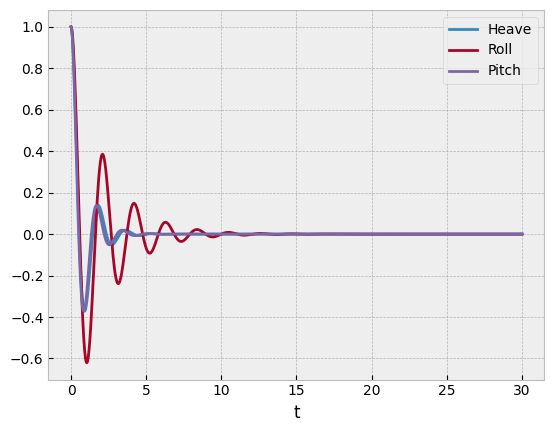

In [38]:
waterplane_area = ship_dim.C_water_plane*ship_dim.L*ship_dim.B
hydrostatics = seakeeping.Hydrostatics(GM_roll, GM_pitch, waterplane_area)

damping_ratios = [damping_ratio_heave, damping_ratio_roll, damping_ratio_pitch]

seakeeping_model = seakeeping.Seakeeping(ship_dim, physical_constants, hydrostatics, inertias, damping_ratios)

seakeeping_model.print_seakeeping_data()
seakeeping_model.plot_decay_response()



## Generate XML formatted FMU parameters that can be directly inserted into an OSP config

In [40]:
osp_param_gen = vessel_model_common.OSPParameterGen(ship_dim, physical_constants, seakeeping_model = seakeeping_model, propeller_model = prop)

#hull_seakeeping parameters
hull_seakeeping_params = osp_param_gen.generate_hull_seakeeping_params()
osp_param_gen.write_to_xml(hull_seakeeping_params, ship_name + '_hull_seakeeping_params.xml')
print("hull_seakeeping parameters:")
osp_param_gen.print_params(hull_seakeeping_params)
print("----------------------------------------------------")

#rigid_body parameters (Simulink version)
rigid_body_params = osp_param_gen.generate_rigid_body_params()
osp_param_gen.write_to_xml(rigid_body_params, ship_name + '_rigid_body_params.xml')
print("rigid_body parameters:")
osp_param_gen.print_params(rigid_body_params)
print("----------------------------------------------------")

hull_seakeeping parameters:
mass	 7200.0
waterplane_area	 19.014
GM_roll	 1.249
GM_pitch	 9.992
heave_damping	 31521.617697
roll_damping	 8720.158509
pitch_damping	 108991.391745
----------------------------------------------------
rigid_body parameters:
m	 7200.0
m_added[1]	 237.6
m_added[2]	 7099.2
m_added[3]	 7228.8
I[1]	 8857.538802
I[2]	 28800.0
I[3]	 28800.0
I_added[1]	 723.064392
I_added[2]	 17971.2
I_added[3]	 20736.0
----------------------------------------------------
